# Import libraries (Pipeline, EDA, data processing)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time
from datetime import datetime, timedelta, date

from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.classifiers.fundamentals import Sector  
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.filters import default_us_equity_universe_mask
from quantopian.pipeline.data import Fundamentals


# Import libraries (preprocessing, machine learning, valuation)

In [2]:

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB




# Set parameters 

In [3]:
MIN_PRICE = 5.0
MAX_PRICE = 1000.0
MIN_MARKET_CAP = 25000000

FIRST_PERIOD = 0
PERIODS_NUM = 8

MISSING_RATE_COL = 0.8
MISSING_RATE_ROW = 0.8
PCA_THRESHOLD = 0.8

CV_FOLDS = 5 
CV_RANDOM_STATE = 111 

LOSS_VECTOR = [5, 0, 0, -2, -5]

BASE_EQUITY = 100000
ASSET_NUMBER = 25


# Create Pipeline

In [4]:


MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcabike camera mountre',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

as_ = morningstar.asset_classification
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_ratios
v = morningstar.valuation
vr = morningstar.valuation_ratios

def make_pipeline():
    
    #universe = QTradableStocksUS()
    universe = (default_us_equity_universe_mask(minimum_market_cap= MIN_MARKET_CAP)) & \
        (USEquityPricing.open.latest > MIN_PRICE) & (USEquityPricing.open.latest < MAX_PRICE) 

    price = USEquityPricing.open.latest
    volume = USEquityPricing.volume.latest
    
    # Morningstar ratios
    growth_score = as_.growth_score.latest
    value_score = as_.value_score.latest
    
    # Valuation ratios
    market_cap = v.market_cap.latest/1000000
    cash_return = vr.cash_return.latest
    cf_yield = vr.cf_yield.latest
    earning_yield = vr.earning_yield.latest
    ev_to_ebitda = vr.ev_to_ebitda.latest
    pb_ratio = vr.pb_ratio.latest
    pe_ratio = vr.pe_ratio.latest
    peg_ratio = vr.peg_ratio.latest
    ps_ratio = vr.ps_ratio.latest
    pcf_ratio = vr.pcf_ratio.latest
    total_yield = vr.total_yield.latest

    # Operation ratios
    ltbe_ratio = or_.long_term_debt_equity_ratio.latest
    current_ratio = or_.current_ratio.latest
    interest_coverage = or_.interest_coverage.latest
    assets_turnover = or_.assets_turnover.latest
    cash_conversion_cycle = or_.cash_conversion_cycle.latest
    days_in_sales = or_.days_in_sales.latest
    net_income_growth = or_.net_income_growth.latest
    sales_per_employee = or_.sales_per_employee.latest
    revenue_growth = or_.revenue_growth.latest
    dps_growth = er.dps_growth.latest
    
    # Margins
    ebit_margin = or_.ebit_margin.latest
    gross_margin = or_.gross_margin.latest
    operation_margin = or_.operation_margin.latest
    net_margin = or_.net_margin.latest

    # Returns
    roa = or_.roa.latest
    roe = or_.roe.latest
    roic = or_.roic.latest
    
    # Momentum   
    class mom_1 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=126)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-1] - prices[-252])/prices[-252] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    class mom_2 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=63)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-21] - prices[-126])/prices[-126] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    class mom_3 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-21] - prices[-63])/prices[-63] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    mom_test_1 = mom_1(mask = universe)
    mom_test_2 = mom_2(mask = universe)
    mom_test_3 = mom_3(mask = universe)
    
    price_mom_M = Returns(window_length=21)
    price_mom_Q = Returns(window_length=63)
    price_mom_H = Returns(window_length=126)
    price_mom_Y = Returns(window_length=252)
 
    # Create Pipeline
    pipe = Pipeline(columns = {"roa" : roa,
                               "roe":roe,
                               "roic" : roic,
                               "operation_margin" : operation_margin,
                               "ebit_margin" : ebit_margin,
                               "gross_margin" : gross_margin,
                               "net_margin" : net_margin,
                               "ltbe_ratio" : ltbe_ratio,
                               "current_ratio" : current_ratio,
                               "interest_coverage" : interest_coverage,
                               "assets_turnover" : assets_turnover,
                               "cash_conversion_cycle" : cash_conversion_cycle,
                               "days_in_sales" : days_in_sales,
                               "net_income_growth" : net_income_growth,
                               "sales_per_employee" : sales_per_employee,
                               "revenue_growth" : revenue_growth,
                               "dps_growth" : dps_growth,
                               "market_cap": market_cap,
                               "cash_return" : cash_return,
                               "cf_yield" : cf_yield,
                               "earning_yield" : earning_yield,
                               "ev_to_ebitda" : ev_to_ebitda,
                               "pb_ratio": pb_ratio,
                               "pe_ratio": pe_ratio,
                               "ps_ratio" : ps_ratio,
                               "pcf_ratio": pcf_ratio,
                               "total_yield" : total_yield,
                               "value_score" :value_score,
                               "growth_score" :growth_score,
                               "mom_test_1" : mom_test_1,
                               "mom_test_2" : mom_test_2,
                               "mom_test_3" : mom_test_3,
                               "price_mom_M" : price_mom_M,
                               "price_mom_Q" : price_mom_Q,
                               "price_mom_H" : price_mom_H,
                               "price_mom_Y" : price_mom_Y,
                               
                               "price": price,
                               "volume": volume
                              },
                   screen = universe)
    return pipe
    
    


# Define functions (time_intervals, get_assets)

In [5]:

def time_intervals(start_year, month, day):            
    years = date.today().year+1-start_year
    dates = pd.date_range(date(start_year, month=month, day=1), periods=years*4, freq='3MS')        
    dates = [date(d.date().year, d.date().month, day)  for d in dates if d.date() < date.today()]
    return dates


def get_assets(f_date, i):
    start_timer = time()

    results = run_pipeline(make_pipeline(), start_date = f_date, end_date= f_date)
    
    end_timer = time()
    print i, f_date, "Time to run pipeline %.2f secs" % (end_timer - start_timer)
    results = results[~results.index.duplicated(keep='first')]      
    results = results.loc[ results.index.get_level_values(0)[0] ]   
    return results
    

# Load universe

In [6]:

START = date(2005, 1, 1)

QUARTERS = time_intervals(START.year, START.month, START.day)

def load_universe():    
    universe = []
    for i in range(len(QUARTERS)):    
        current_date = QUARTERS[i]   
        df = get_assets(current_date, i)
        universe.append(df)
    return universe

UNIVERSE = load_universe()


/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


0 2005-01-01 Time to run pipeline 11.91 secs
1 2005-04-01 Time to run pipeline 6.92 secs
2 2005-07-01 Time to run pipeline 6.37 secs
3 2005-10-01 Time to run pipeline 6.30 secs
4 2006-01-01 Time to run pipeline 6.10 secs
5 2006-04-01 Time to run pipeline 6.92 secs
6 2006-07-01 Time to run pipeline 6.40 secs
7 2006-10-01 Time to run pipeline 6.30 secs
8 2007-01-01 Time to run pipeline 6.83 secs
9 2007-04-01 Time to run pipeline 6.35 secs
10 2007-07-01 Time to run pipeline 6.42 secs
11 2007-10-01 Time to run pipeline 6.98 secs
12 2008-01-01 Time to run pipeline 6.36 secs
13 2008-04-01 Time to run pipeline 6.19 secs
14 2008-07-01 Time to run pipeline 7.02 secs
15 2008-10-01 Time to run pipeline 6.75 secs
16 2009-01-01 Time to run pipeline 6.46 secs
17 2009-04-01 Time to run pipeline 6.84 secs
18 2009-07-01 Time to run pipeline 6.32 secs
19 2009-10-01 Time to run pipeline 6.36 secs
20 2010-01-01 Time to run pipeline 6.28 secs
21 2010-04-01 Time to run pipeline 6.85 secs
22 2010-07-01 Time 

In [8]:
print "number of periods:", len(UNIVERSE)


number of periods: 58


#Loss function

In [9]:
def loss_func (cm):
    loss_value = (cm[0,0]*LOSS_VECTOR [0] + cm[1,1]*LOSS_VECTOR[1] + cm[2,2]*LOSS_VECTOR[0]  +
                 cm[0,1]*LOSS_VECTOR [2] + cm[0,2]*LOSS_VECTOR[4] + 
                 cm[1,0]*LOSS_VECTOR [3] + cm[1,2]*LOSS_VECTOR[3] +
                 cm[2,0]*LOSS_VECTOR [4] + cm[2,1]*LOSS_VECTOR[3])
    return loss_value



# Put together results

In [10]:

def index_of_t(first_period, t):
    return (first_period + PERIODS_NUM - 1) - t

def assemble_dataframe(first_period):
    results = UNIVERSE[index_of_t(first_period, 0)]
    for t in range(1, PERIODS_NUM):        
        results = results.join(UNIVERSE[index_of_t(first_period, t)], rsuffix='_%d' % t, how='outer')    

    return results

# Get future prices

In [11]:

def get_future_prices(first_period):        
    future_price = UNIVERSE[index_of_t(first_period, -1)]['price']    
    future_price = pd.DataFrame(future_price)
    future_price.rename(columns = {0:"price"}, inplace= True) 
    future_price.drop(future_price[future_price['price'].isnull()].index, inplace=True)
    return future_price


# Handle missing data 

In [12]:
def column_of_t(name, t):
    if t == 0:
        return name
    else:
        return name+'_%d' % t
    
def columns_of(name):
    names = []
    for i in range(PERIODS_NUM):
        names.append(column_of_t(name, i))
    return names

def clean_dataframe(df):
    print "cleaning data..."
    print df.isnull().sum().sum()
    start_timer = time()
    df.drop(df[df['price'].isnull()].index, inplace=True)
    
    threshold = len(df) * MISSING_RATE_COL
    df.dropna(thresh = threshold, axis = 1, inplace = True)
    
    threshold = len(df.columns) * MISSING_RATE_ROW
    df.dropna(thresh = threshold, axis = 0, inplace= True)
    
    print df.isnull().sum().sum()
            
    for column in UNIVERSE[0].columns:
        current_columns = columns_of(column)
        existing_columns = df.columns & set(current_columns)
        
        df[existing_columns] = df[existing_columns].fillna(method='bfill', axis=1)
        df[existing_columns] = df[existing_columns].fillna(method='ffill', axis=1)
        
        for ec in existing_columns:
            df[ec] = df[ec].fillna(df[ec].mean())
                
    print df.isnull().sum().sum()
        
    end_timer = time()
    print "Time to clean: %.2f secs" % (end_timer - start_timer)
    return df


# Compute target variable

In [13]:
def compute_target(fundamentals, future_prices):
    target = (future_prices["price"] - fundamentals["price"]) / fundamentals["price"]
    target = target.rank()
    target = target.apply(lambda x: 
                        "Top" if x > len(target)*2/3 
                        else "Mid" if x >= len(target)*1/3
                        else "Bot")
    return target

# Preparing Machine Learning


## Standardisation

In [14]:
def standardize(df_X):
    names = df_X.columns
    index = df_X.index
    scaler = preprocessing.StandardScaler()
    df_X = scaler.fit_transform(df_X)
    df_X = pd.DataFrame(df_X, index=index, columns=names)
    return df_X

## PCA - number of components and compression

In [15]:

TRAINING_N_PCA = None

def training_pca(df_X):    
    global TRAINING_N_PCA
    explained_var = []

    for n_components in range(len(df_X.columns)):
        pca = PCA(n_components=n_components)        
        pca.fit_transform(df_X)
        explain = sum(pca.explained_variance_ratio_)
        explained_var.append(explain)

    n_pca = 1

    for i in range (len (explained_var)):
        if explained_var [i] < PCA_THRESHOLD:
            n_pca  +=1
    
    TRAINING_N_PCA = n_pca
    pca = PCA(n_components = n_pca)
    principalDf = pd.DataFrame(pca.fit_transform(df_X), index=df_X.index)
    
    print "Number of PC-s. ", n_pca
    print "Variance explained by PCA: ", sum(pca.explained_variance_ratio_)
    
    return principalDf

def prediction_pca(df_X):
    pca = PCA(n_components = TRAINING_N_PCA)
    principalDf = pd.DataFrame(pca.fit_transform(df_X), index=df_X.index)
    return principalDf


## Data preparation

In [16]:
def prepare_data(index):
    fundamentals = assemble_dataframe(index)
    fundamentals = clean_dataframe(fundamentals)
    
    future_prices = get_future_prices(index)
    print 'fundamentals:', len(fundamentals), 'rows, future prices:', len(future_prices), 'rows'
    common_assets = (fundamentals.index & future_prices.index)
    fundamentals = fundamentals.loc[common_assets]
    future_prices = future_prices.loc[common_assets]
    print 'Lenght of common section:', len(common_assets)
    target = compute_target(fundamentals, future_prices)      
    return fundamentals, target, future_prices
    

## Training data and validation data

In [17]:
def training_data(index):
    global X_train, X_val, y_train, y_val
    fundamentals, target, _future_price = prepare_data(index)
    df_X = standardize(fundamentals)  
    principalDf = training_pca(df_X)
    X_train, X_val, y_train, y_val = train_test_split(principalDf, target, test_size=0.2, random_state=CV_RANDOM_STATE)


## Prediction data 

In [18]:
def prediction_data(index):
    fundamentals, _target, future_prices = prepare_data(index+1)
    prices = pd.DataFrame({'price': fundamentals['price'], 'future_price': future_prices['price']}, index=fundamentals.index)    
    df_X = standardize(fundamentals) 
    principalDf = prediction_pca(df_X)
    return principalDf, prices
    

# Model Selection - GridSearch

## K-nearest neighbors - KNN

In [19]:
def knn():
    print "KNN"
    start_timer = time()
    
    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE)
    
    classifier = KNeighborsClassifier()  

    grid_param = {  
        'n_neighbors': [25,39, 55],
        'weights': ['uniform', "distance"],
        'algorithm': ["ball_tree", "kd_tree", "auto"]
    }

    knn_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    knn_grid.fit(X_train, y_train)  

    knn_val = knn_grid.predict(X_val)
    knn_cm = confusion_matrix(y_val, knn_val)
    knn_cr = classification_report(y_val, knn_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    
    return {"model": knn_grid, "name": "KNN", "value": loss_func(knn_cm)}


## Random forest - RFC

In [20]:
def rfc():
    print "Random forest"
    start_timer = time()

    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE)    
    classifier = RandomForestClassifier()  

    grid_param = {  
        'n_estimators': [10, 100, 1000],
        'criterion': ['gini'],
        'bootstrap': [True, False]
    }

    rfc_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    rfc_grid.fit(X_train, y_train)   

    rfc_val = rfc_grid.predict(X_val)
    rfc_cm = confusion_matrix(y_val, rfc_val)
    rfc_cr = classification_report(y_val, rfc_val)
    
    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    return {"model": rfc_grid, "name": "RFC", "value": loss_func(rfc_cm)}



## Support vector classifier - SVC

In [21]:
def svc():
    print "SVC"
    start_timer = time()

    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE)    
    classifier = SVC(probability=True)  

    grid_param = {  
        'C': [ 0.1, 1],
        'kernel': ['rbf', "linear"]
    }

    svc_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    svc_grid.fit(X_train, y_train)  

    svc_val = svc_grid.predict(X_val)
    svc_cm = confusion_matrix(y_val, svc_val)
    svc_cr = classification_report(y_val, svc_val)
   
    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    return {"model": svc_grid, "name": "SVC", "value": loss_func(svc_cm)}


## Logistic regression model - LGM

In [22]:
def lgm():
    print "LGM"
    start_timer = time()

    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE)    
    classifier = LogisticRegression()  

    grid_param = {  
        'penalty': ['l1', "l2"],
        'C': [0.01, 0.1, 1],
        'solver': ['newton-cg', 'lbfgs', "liblinear"],
        'verbose': [1]
    }

    lgm_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    lgm_grid.fit(X_train, y_train)  

    lgm_val = lgm_grid.predict(X_val)
    lgm_cm = confusion_matrix(y_val, lgm_val)
    lgm_cr = classification_report(y_val, lgm_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    return {"model": lgm_grid, "name": "LGM", "value": loss_func(lgm_cm)}


# Gradient boosting model - GBM

In [23]:
def gbm():
    print "GBM"
    start_timer = time()

    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE) 
    
    classifier = GradientBoostingClassifier()  

    grid_param = {  
        'loss': ['deviance'],
        'learning_rate': [0.001, 0.01],
        'n_estimators': [100, 1000],
        'max_depth': [1, 3],
        'max_features':['auto']
    }

    gbm_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    gbm_grid.fit(X_train, y_train)  

    gbm_val = gbm_grid.predict(X_val)
    gbm_cm = confusion_matrix(y_val, gbm_val)
    gbm_cr = classification_report(y_val, gbm_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    return {"model": gbm_grid, "name": "GBM", "value": loss_func(gbm_cm)}

# Gaussian naive bayes - GNB

In [24]:
def gnb():
    print "GNB"
    start_timer = time()
    
    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE)
    
    classifier =  GaussianNB ()

    grid_param = {  
       }

    gnb_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    gnb_grid.fit(X_train, y_train)
    
    gnb_val = gnb_grid.predict(X_val)
    gnb_cm = confusion_matrix(y_val, gnb_val)
    gnb_cr = classification_report(y_val, gnb_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    return {"model": gnb_grid, "name": "GNB", "value": loss_func(gnb_cm)}

## Select best model

In [25]:
def select():
    global loss_models
    loss_models = [
        knn(),
        svc(),
        lgm(), 
        rfc(),
        gbm(),
        gnb()
    ]
    print "Losses", map(lambda f: (f["name"], f["value"]), loss_models)
    return sorted(loss_models, key = lambda i: i["value"], reverse=True)[0]

## Buy list and Sell list

In [26]:
def buy(buy_list, prices, equity):
    equity_per_share = equity / len(buy_list)
    b = pd.DataFrame({'equity': equity_per_share}, index=buy_list)
    b = b.join(prices['price'])
    b = b.join(prices['future_price'])
    b['shares'] = (b['equity'] / b['price']).round() - 1  
    b['revenue'] = b['shares'] * b['future_price']
    b['profit'] = b['revenue'] - b['equity']
    return b 


def sell(sell_list, prices, equity):    
    equity_per_share = equity / len(sell_list)
    s = pd.DataFrame({'equity': equity_per_share}, index=sell_list)
    s = s.join(prices['price'])
    s = s.join(prices['future_price'])
    s['shares'] = (s['equity'] / s['price']).round() - 1  
    s['revenue'] = s['shares'] * s['future_price']
    s['profit'] = s['equity'] - s['revenue']
    return s 


# Run the whole process

In [27]:

def run():  
    
    start_timer = time()

    global equity_array, equity, equity_array_long_short, equity_long_short, equity_array_long, \
                equity_long, equity_array_short, equity_short
    global long_short_assets_buys, long_short_assets_sells, long_assets, short_assets
    
    long_short_assets_buys = []
    long_short_assets_sells = []
    long_assets = []
    short_assets = []    
    
    equity = BASE_EQUITY
    equity_array = [equity]
    
    equity_long_short = BASE_EQUITY
    equity_array_long_short = [equity]
    
    equity_long = BASE_EQUITY
    equity_array_long = [equity]
    
    equity_short = BASE_EQUITY
    equity_array_short = [equity]
    
    for i in range(FIRST_PERIOD, len(UNIVERSE)-PERIODS_NUM-1):    #len(UNIVERSE)-PERIODS_NUM-1):     
        print i, "run"
        training_data(i)
        best = select()
        print "best model: ", best["name"], best["value"]
        best_model = best["model"]
    
        next_dataset, next_prices = prediction_data(i)
        
        predictions = pd.DataFrame(best_model.predict_proba(next_dataset), index=next_dataset.index, columns=best_model.best_estimator_.classes_)
        
        buy_list = predictions['Top'].sort_values(ascending=False)[:ASSET_NUMBER].index
        
        sell_list = predictions['Bot'].sort_values(ascending=False)[:ASSET_NUMBER].index
        
        print ""
        buys = buy(buy_list, next_prices, equity_long_short)
        sells = sell(sell_list, next_prices, equity_long_short)        
        long_short_assets_buys.append(buys)
        long_short_assets_sells.append(sells)
        
        long_short_profit = buys['profit'].sum() + sells['profit'].sum()
        equity_long_short += long_short_profit
        equity_array_long_short.append(equity_long_short)
        print "LONG_SHORT Profit: ", long_short_profit, "Equity: ", equity_long_short


        print ""
        buys = buy(buy_list, next_prices, equity_long)
        long_assets.append(buys)
        
        long_only = buys['profit'].sum()        
        equity_long += long_only
        equity_array_long.append(equity_long)
        print "LONG_Only Profit :", long_only, "Equity: ", equity_long
        
        
        print ""
        sells = sell(sell_list, next_prices, equity_short)
        short_assets.append(sells)
        
        short_only = sells['profit'].sum()
        equity_short += short_only
        equity_array_short.append(equity_short)        
        print "SHORT_Only Profit :", short_only, "Equity: ", equity_short
        
        print ""
        end_timer = time()
        print "Time needed to run %.2f secs" % (end_timer - start_timer)

        print "*******************************"
        
        if equity_long_short < 0:
            print "GAME OVER!"
            break

In [28]:
run()

0 run
cleaning data...
382763
12129
0
Time to clean: 0.22 secs
fundamentals: 2985 rows, future prices: 3701 rows
Lenght of common section: 2904
Number of PC-s.  35
Variance explained by PCA:  0.809281922622
KNN


/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:385: UserWarning: n_jobs is ignored, not running in parallel
  self.n_jobs = n_jobs


Time to create model 6.24 secs
SVC
Time to create model 64.79 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 8.27 secs
Random forest
Time to create model 112.35 secs
GBM
Time to create model 124.91 secs
GNB
Time to create model 0.04 secs
Losses [('KNN', -230), ('SVC', -151), ('LGM', -214), ('RFC', -260), ('GBM', -184), ('GNB', -358)]
best model:  SVC -151
cleaning data...
391126
11728
0
Time to clean: 0.21 secs
fundamentals: 3020 rows, future prices: 3667 rows
Lenght of common section: 2926

LONG_SHORT Profit:  9641.00552044 Equity:  109641.00552

LONG_Only Profit : 4404.9030474 Equity:  104404.903047

SHORT_Only Profit : 5236.10247304 Equity:  105236.102473

Time needed to run 

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:655: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 10.19 secs
Random forest
Time to create model 127.66 secs
GBM
Time to create model 139.30 secs
GNB
Time to create model 0.04 secs
Losses [('KNN', 67), ('SVC', 169), ('LGM', -67), ('RFC', 97), ('GBM', 70), ('GNB', -72)]
best model:  SVC 169
cleaning data...
392027
12214
0
Time to clean: 0.22 secs
fundamentals: 3010 rows, future prices: 3711 rows
Lenght of common section: 2921

LONG_SHORT Profit:  11335.0 Equity:  120976.00552

LONG_Only Profit : 10549.8769526 Equity:  114954.78

SHORT_Only Profit : 306.512473039 Equity:  105542.614946

Time needed to run 701.40 secs
*******************************
2 run
cleaning data...
392027
12214
0
Time to clean: 0.22 secs
fundamentals: 3010 rows, future prices: 3711 rows
Lenght of common section: 2921
Number of PC-s.  38
Variance explained by PCA:  0.809980022153
KNN
Time to create model 6.29 secs
SVC
Time to 

0
Time to clean: 0.23 secs
fundamentals: 2757 rows, future prices: 2663 rows
Lenght of common section: 2331
Number of PC-s.  36
Variance explained by PCA:  0.813034640519
KNN
Time to create model 4.12 secs
SVC
Time to create model 45.71 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 8.27 secs
Random forest
Time to create model 95.08 secs
GBM
Time to create model 120.31 secs
GNB
Time to create model 0.03 secs
Losses [('KNN', 190), ('SVC', 153), ('LGM', 154), ('RFC', 211), ('GBM', 154), ('GNB', -43)]
best model:  RFC 211
cleaning data...
395621
9889
0
Time to clean: 0.23 secs
fundamentals: 2370 rows, future prices: 2490 rows
Lenght of common section: 2186

LONG_SHORT Pr

0
Time to clean: 0.21 secs
fundamentals: 2476 rows, future prices: 3026 rows
Lenght of common section: 2422

LONG_SHORT Profit:  6949.561 Equity:  134411.517064

LONG_Only Profit : 6869.534 Equity:  79052.05

SHORT_Only Profit : -6599.56186288 Equity:  137601.226274

Time needed to run 4789.59 secs
*******************************
15 run
cleaning data...
312817
12043
0
Time to clean: 0.21 secs
fundamentals: 2476 rows, future prices: 3026 rows
Lenght of common section: 2422
Number of PC-s.  38
Variance explained by PCA:  0.811147747309
KNN
Time to create model 4.54 secs
SVC
Time to create model 48.90 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 7.87 secs
Random forest
Time to cr

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 8.16 secs
Random forest
Time to create model 100.15 secs
GBM
Time to create model 124.36 secs
GNB
Time to create model 0.04 secs
Losses [('KNN', 48), ('SVC', 89), ('LGM', 98), ('RFC', 156), ('GBM', 92), ('GNB', -193)]
best model:  RFC 156
cleaning data...
265902
12074
0
Time to clean: 0.23 secs
fundamentals: 2551 rows, future prices: 3069 rows
Lenght of common section: 2495

LONG_SHORT Profit:  17109.1365974 Equity:  156033.214988

LONG_Only Profit : -546.88 Equity:  97498.3

SHORT_Only Profit : 13298.249324 Equity:  115100.730521

Time needed to run 6975.53 secs
*******************************
22 run
cleaning data...
265902
12074
0
Time to 

0
Time to clean: 0.22 secs
fundamentals: 2691 rows, future prices: 3401 rows
Lenght of common section: 2642
Number of PC-s.  33
Variance explained by PCA:  0.812815762105
KNN
Time to create model 4.89 secs
SVC
Time to create model 50.38 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 10.27 secs
Random forest
Time to create model 92.81 secs
GBM
Time to create model 108.48 secs
GNB
Time to create model 0.04 secs
Losses [('KNN', -62), ('SVC', 42), ('LGM', -95), ('RFC', 2), ('GBM', -31), ('GNB', -400)]
best model:  SVC 42
cleaning data...
269647
9052
0
Time to clean: 0.22 secs
fundamentals: 2729 rows, future prices: 3457 rows
Lenght of common section: 2685

LONG_SHORT Prof

0
Time to clean: 0.22 secs
fundamentals: 2863 rows, future prices: 3348 rows
Lenght of common section: 2722

LONG_SHORT Profit:  14081.4672561 Equity:  143225.281465

LONG_Only Profit : -14795.8044268 Equity:  111371.971573

SHORT_Only Profit : 17516.9188055 Equity:  93845.8076111

Time needed to run 11194.71 secs
*******************************
35 run
cleaning data...
281734
11775
0
Time to clean: 0.22 secs
fundamentals: 2863 rows, future prices: 3348 rows
Lenght of common section: 2722
Number of PC-s.  37
Variance explained by PCA:  0.807499100886
KNN
Time to create model 5.67 secs
SVC
Time to create model 60.19 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 8.42 se

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 9.01 secs
Random forest
Time to create model 111.72 secs
GBM
Time to create model 131.56 secs
GNB
Time to create model 0.04 secs
Losses [('KNN', 15), ('SVC', 107), ('LGM', 87), ('RFC', 192), ('GBM', 170), ('GNB', -227)]
best model:  RFC 192
cleaning data...
285994
12209
0
Time to clean: 0.24 secs
fundamentals: 2737 rows, future prices: 3310 rows
Lenght of common section: 2665

LONG_SHORT Profit:  -3509.626 Equity:  147698.243729

LONG_Only Profit : 1336.115 Equity:  141933.01

SHORT_Only Profit : -1161.58050047 Equity:  78704.4259991

Time needed to run 13730.04 secs
*******************************
42 run
cleaning data...
285994
1


LONG_SHORT Profit:  31234.72 Equity:  213284.016493

LONG_Only Profit : -22552.4051011 Equity:  153675.19

SHORT_Only Profit : 24586.9146876 Equity:  106580.689375

Time needed to run 15792.24 secs
*******************************
48 run
cleaning data...
302638
8996
0
Time to clean: 0.31 secs
fundamentals: 2766 rows, future prices: 3200 rows
Lenght of common section: 2624
Number of PC-s.  36
Variance explained by PCA:  0.807745513462
KNN
Time to create model 5.85 secs
SVC
Time to create model 54.99 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 14.70 secs
Random forest
Time to create model 117.22 secs
GBM
Time to create model 131.77 secs
GNB
Time to create model 0.04 

## Calculate CAGR

In [29]:
def CAGR ():    
    
    start_cap = profit_table["Long_Shorts"].loc[0]
    Long_Shorts_end = profit_table["Long_Shorts"].iloc[-1]
    CAGR_Long_Shorts = (((Long_Shorts_end/start_cap)**(1.0 / 12)) -1)* 100
    print '-- CAGR_Long_Shorts: %.1f %%     ' % (CAGR_Long_Shorts)

    Longs_end = profit_table["Longs"].iloc[-1]
    CAGR_Longs = (((Longs_end/start_cap)**(1.0 / 12)) -1)* 100
    print '-- CAGR_Longs:       %.1f %%        ' % (CAGR_Longs)

    Shorts_end = profit_table["Shorts"].iloc[-1]
    CAGR_Shorts = (((Shorts_end/start_cap)**(1.0 / 12)) -1)* 100
    print '-- CAGR_Shorts:      %.1f %%        ' % (CAGR_Shorts)

    SPY_end = 180000
    CAGR_SPY = (((SPY_end/start_cap)**(1.0 / 12)) -1)* 100
    print '-- CAGR_SPY:         %.1f %%        ' % (CAGR_SPY)


## Profit table and chart of equity

In [30]:
profit_table = []
def equity_chart():
    
    global profit_table
    longshorts = pd.DataFrame(data= {"Long_Shorts":(equity_array_long_short)})
    longs = pd.DataFrame (data = {"Longs": equity_array_long}) 
    shorts = pd.DataFrame (data = {"Shorts": equity_array_short})
    profit_table = pd.concat([longshorts, longs, shorts], axis = 1, join_axes=[longs.index])
    
    CAGR()
    
    profit_table['date'] = QUARTERS[FIRST_PERIOD+PERIODS_NUM:FIRST_PERIOD+PERIODS_NUM+len(profit_table)]
    profit_table.set_index('date', inplace=True)
    
    profit_table.plot(title = "Plot Equity Curves: All stretegy")
    
    

-- CAGR_Long_Shorts: 7.3 %     
-- CAGR_Longs:       5.0 %        
-- CAGR_Shorts:      -0.2 %        
-- CAGR_SPY:         5.0 %        


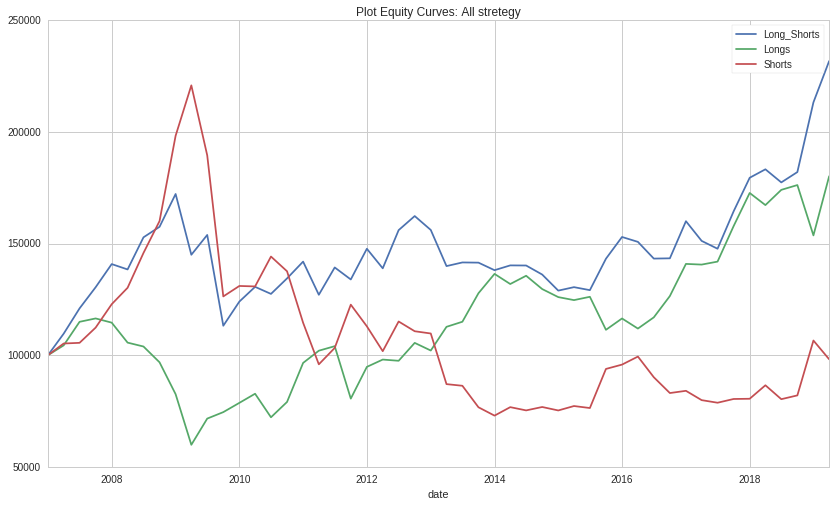

In [31]:
equity_chart()

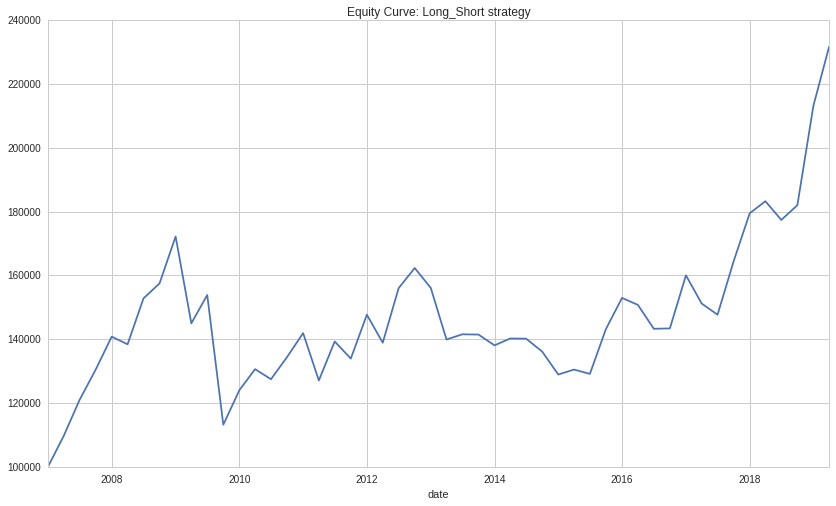

In [32]:
profit_table["Long_Shorts"].plot(title = "Equity Curve: Long_Short strategy");

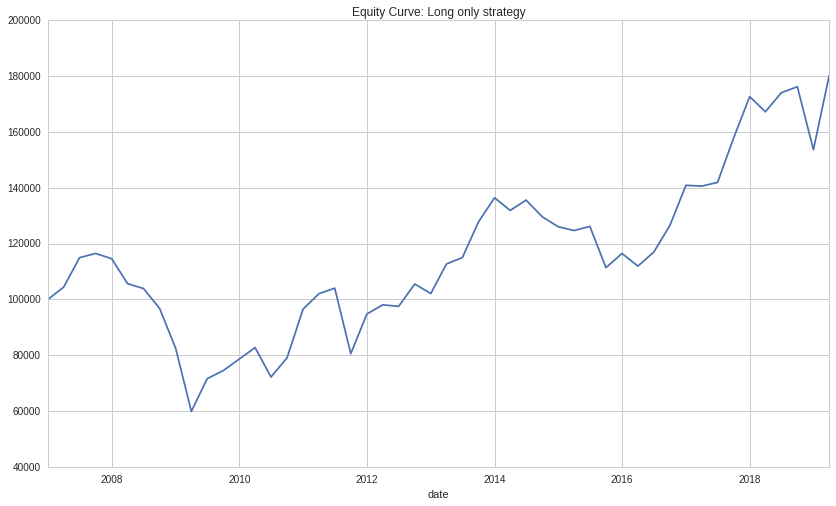

In [33]:
profit_table["Longs"].plot(title = "Equity Curve: Long only strategy");

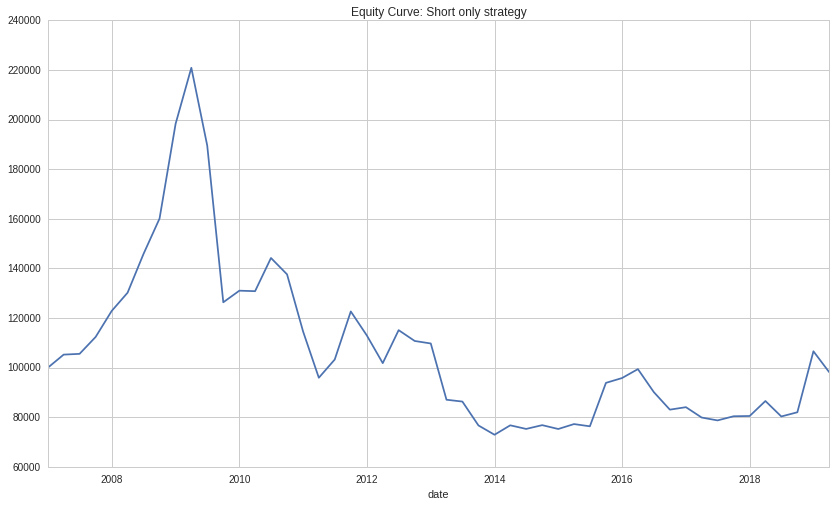

In [34]:
profit_table["Shorts"].plot(title ="Equity Curve: Short only strategy");

# Lists to control and monitor trading activity

In [ ]:
long_short_assets_buys

In [ ]:
long_short_assets_sells

In [ ]:
long_assets[1]

In [ ]:
short_assets[0]